# Spark SQL

## Setup

In [60]:
import re
from typing import Optional

import cartopy.crs as crs
import matplotlib.pyplot as plt
import numpy as np
import findspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, udf
from pyspark.sql.types import FloatType, IntegerType, StringType

### Spark initialization

In [61]:
findspark.init()
spark = SparkSession \
    .builder \
    .config("spark.sql.catalogImplementation", "in-memory") \
    .getOrCreate()
sc = spark.sparkContext
spark

### Get datasets

2 datasets will be used:
- "countries" - geographic, economical and demographical data about various countries
- "airports" - data about airports from around the world

In [62]:
countries = spark.read.csv("countries.csv", inferSchema=True, header=True)
airports = spark.read.csv("airports.csv", inferSchema=True, header=True)

In [63]:
countries.toPandas().head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None


In [64]:
airports.toPandas().head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [65]:
countries.createOrReplaceTempView("countries")
airports.createOrReplaceTempView("airports")

## Infant mortality vs literacy

Plot the relation between `Infant mortality` and `Literacy` for 30 richest and 30 poorest countries.

First we need to convert `Literacy` column to proper type, i.e. replace commas with dots and make floats.

In [66]:
float_udf = udf(
    lambda s: float(s.replace(",", ".")),
    FloatType()
)

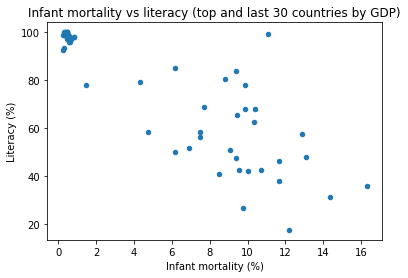

In [67]:
df = (
    countries
    .select(
        "Infant mortality (per 1000 births)",
        "Literacy (%)",
        "GDP ($ per capita)"
    )
    
    # drop NAs
    .na.drop()
    
    # convert strings to floats
    .withColumn(
        "Infant mortality (per 1000 births)",
        float_udf("Infant mortality (per 1000 births)")
    )
    .withColumn(
        "Literacy (%)",
        float_udf("Literacy (%)")
    )
    
    # convert infant mortality to percents
    .withColumn(
        "Infant mortality (%)",
        col("Infant mortality (per 1000 births)") / 10
    )
    .drop("Infant mortality (per 1000 births)")
    
    # sort
    .orderBy("GDP ($ per capita)")
)

df = spark.createDataFrame(df.head(30) + df.tail(30))

ax = df.toPandas().plot.scatter(
    x="Infant mortality (%)",
    y="Literacy (%)"
)
ax.set_title("Infant mortality vs literacy (top and last 30 countries by GDP)")
plt.show()

## Plot airports on map

Plot all airport locations on map.

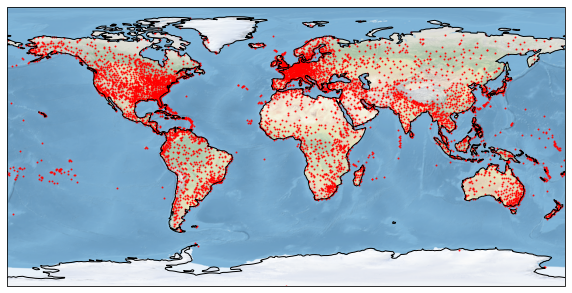

In [68]:
df = airports.select("Latitude","Longitude").toPandas()

plt.figure(figsize=[10, 10])
ax = plt.axes(projection=crs.PlateCarree())
ax.stock_img()
ax.coastlines()

lats = df["Latitude"].tolist()
longs = df["Longitude"].tolist()

plt.scatter(
    x=longs,
    y=lats,
    color="r",
    s=1,
    alpha=0.8,
    transform=crs.PlateCarree()
)

plt.show()

Why are there airports on the sea? Perhaps there are small islands there with very small airports for small planes.

## Convert units

Create two new columns in "Countries" DataFrame, where area and density will be in square miles and people per square mile, respectively.

At the first glance this does not make sense - there are features `Area (sq. mi.)` and `Pop. Density (per sq. mi.)`. However, after closer inspection the data states that, for example:
- Afghanistan has 647500 square miles, while in reality it has about 652 thousand square kilometers
- Albania has 28748 square miles, while in reality it has about 29 thousand square kilometers

So the unit is actually incorrect and we need to recalculate area and population density to make column labels correct.

In [80]:
sq_km_to_sq_mi_udf = udf(
    lambda area: int(area * 0.386102159),
    IntegerType()
)


def pop_density(population: int, area: int) -> float:
    if not area:
        return 0
    else:
        return population / area


pop_density_udf = udf(pop_density,FloatType())

In [82]:
df = (
    countries
    
    # rename to reflect real units
    .withColumnRenamed("Area (sq. mi.)", "Area (sq km)")
    .withColumnRenamed("Pop. Density (per sq. mi.)", "Pop. Density (per sq km)")
    
    # calculate proper area and population density
    .withColumn("Area (sq mi)", sq_km_to_sq_mi_udf("Area (sq km)"))
    .withColumn("Pop. Density (per sq mi)", pop_density_udf("Population", "Area (sq mi)"))
    
    .select("Area (sq mi)", "Area (sq km)", "`Pop. Density (per sq mi)`", "`Pop. Density (per sq km)`")
)

df.toPandas()

,Area (sq mi),Area (sq km),Pop. Density (per sq mi),Pop. Density (per sq km)
0,250001,647500,124.227493,"48,0"
1,11099,28748,322.700684,"124,6"
2,919594,2381740,35.809380,"13,8"
3,76,199,760.447388,"290,4"
4,180,468,395.561096,"152,1"
...,...,...,...,...
222,2262,5860,1087.750610,"419,9"
223,102703,266000,2.658228,"1,0"
224,203850,527970,105.254784,"40,6"
225,290585,752614,39.582256,"15,3"


## Plot number of airports vs country area

Create scatterplot with relation of number of airports and country area.

In [83]:
def normalize_country_name(s: str) -> str:
    s = s.replace("&", "and") \
        .replace(", The", "") \
        .replace("Rep.", "Republic") \
        .replace("Korea, North", "North Korea") \
        .replace("Korea, South", "South Korea") \
        .replace("Is.", "Island") \
        .replace("Islands", "Island")
    
    s = re.sub("Is(\s+|$)", "Island", s)
    s = re.sub("Congo.*", "Congo", s)
    s = re.sub("Micronesia.*", "Micronesia", s)
    
    return s.strip()

normalize_country_name_udf = udf(
    lambda s: normalize_country_name(s),
    StringType()
)

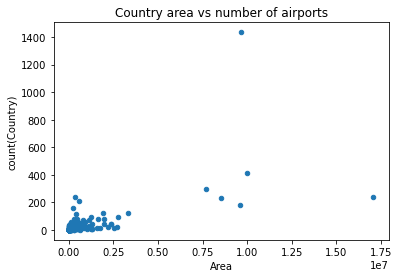

In [84]:
df_countries = (
    countries
    .withColumnRenamed("Area (sq. mi.)", "Area")
    .select("Country", "Area")
    .withColumn("Country", normalize_country_name_udf("Country"))
)

df_airports = (
    airports
    .select("Country")
    .withColumn("Country", normalize_country_name_udf("Country"))
)

df = (
    df_countries
    .join(df_airports, on="Country", how="left")
    .groupBy("Country", "Area")
    .agg(count("Country"))
    .drop("Country")
    .orderBy("Area")
)

ax = df.toPandas().plot.scatter(
    x="Area",
    y="count(Country)"
)
ax.set_title("Country area vs number of airports")
plt.show()

## Plot number of airports per continent

Plot how many airports are on different continents. Use the "Region" column to map countries to continents.

In [85]:
def region_to_continent(s: str) -> str:
    continents_map = {
        "ASIA": "Asia",
        "AFRICA": "Africa",
        "BALTICS": "Europe",
        "EUROPE": "Europe",
        "IND. STATES": "Asia",
        "LATIN AMER": "South America",
        "NEAR EAST": "Africa",
        "NORTHERN AMERICA": "North America",
        "OCEANIA": "Australia/Oceania",
    }
    
    for key, val in continents_map.items():
        if key in s:
            return val
    
    return "Other"

region_to_continent_udf = udf(
    lambda s: region_to_continent(s),
    StringType()
)

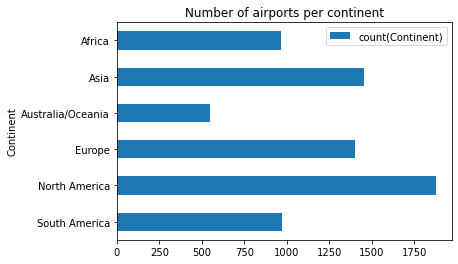

In [86]:
df_countries = (
    countries
    .select("Country", "Region")
    .withColumn("Country", normalize_country_name_udf("Country"))
    .withColumn("Continent", region_to_continent_udf("Region"))
    .drop("Region")
)

df_airports = (
    airports
    .select("Country")
    .withColumn("Country", normalize_country_name_udf("Country"))
)

df = (
    df_countries
    .join(df_airports, on="Country", how="left")
    .drop("Country")
    .groupBy("Continent")
    .agg(count("Continent"))
    .orderBy(desc("Continent"))
)

ax = df.toPandas().plot.barh(
    x="Continent",
    y="count(Continent)",
    title="Number of airports per continent"
)
plt.show()